# Reproducing any Pysm model for a list of frequencies using moment maps

This code allows to reproduce any Pysm 3 model using moment maps and test the accuracy of the derivation at different order

In [1]:
# all imports:
import numpy as np
import pylab

pylab.rcParams["figure.figsize"] = 12, 16
import healpy as hp
import pysm3
import pysm3.units as u
import scipy.constants as constants
import matplotlib
import pymaster as nmt
from scipy.stats import median_abs_deviation as mad
import funclib as lib

plt.rcParams["font.family"] = "sans-serif"

# Create the PYSM map for a list of frequencies, compute its moments and approximate it with a moment expansion

In [2]:
# general keywords
instr = "LiteBIRD"  # instrument to get the frequencies at which the model should be computed
nside = 512
fgtype = "d10"  # foreground model for Pysm
pivot_type = "2D"  # pivot_type either '2D' or '3D'
omax = 7  # maximum order at which to compute the moments

npix = hp.nside2npix(nside)

if fgtype[0] == "d":
    model_type = "mbb"
elif fgtype[0] == "s":
    model_type = "pl"

# pick frequencies
if instr == "Planck_HFI":
    freq = np.array([100, 143, 217, 353])
    sig = (
        np.array([1.96, 1.17, 1.75, 7.31]) * 60
    )  # From Planck2018 .I.: μKCMB.deg  --> μKCMB.arcmin
if instr == "LiteBIRD":
    freq = np.array(
        [
            40.0,
            50.0,
            60.0,
            68.0,
            78.0,
            89.0,
            100.0,
            119.0,
            140.0,
            166.0,
            195.0,
            235.0,
            280.0,
            337.0,
            402.0,
        ]
    )
    sig = np.array(
        [
            37.42,
            33.46,
            21.31,
            15.38543566,
            10.80880632,
            9.24672677,
            5.91733952,
            4.1387723,
            4.19965338,
            5.57,
            5.7675921,
            10.79,
            13.8,
            21.95,
            47.45,
        ]
    )  # from LiteBIRD-PTEP's paper arxiv:2202.02773
N_freq = len(freq)
sigpix = sig / (hp.nside2resol(512, arcmin=True))

# Generate Pysm maps at instrument frequencies

sky = pysm3.Sky(nside=nside, preset_strings=[fgtype])
model = np.array(
    [
        sky.get_emission(freq[f] * u.GHz)
        .to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f] * u.GHz))
        .value
        for f in range(len(freq))
    ]
)

if model_type == "mbb":
    dust = sky.components[0]
    if fgtype == "d12":
        betamap = dust.mbb_index.value
        tempmap = dust.mbb_temperature.value
        nu0 = dust.freq_ref.value
        AI = dust.layers.to(
            u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0 * u.GHz)
        ).value
    else:
        nu0 = dust.freq_ref_P.value
        betamap = np.array([dust.mbb_index.value])
        tempmap = np.array([dust.mbb_temperature.value])
        AI = np.array(
            [
                dust.get_emission(nu0 * u.GHz)
                .to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0 * u.GHz))
                .value
            ]
        )
elif model_type == "pl":
    sync = sky.components[0]
    nu0 = sync.freq_ref_P.value
    betamap = np.array([sync.pl_index.value])
    AI = np.array(
        [
            sync.get_emission(nu0 * u.GHz)
            .to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0 * u.GHz))
            .value
        ]
    )
    tempmap = None

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Here is the function computing the moments with respect to $p\in \beta^d,1/T^d,\beta^s$ up to order $\alpha$. For auto-moments (the simplest case), it is given by

$$\mathcal{W}^p_\alpha = \frac{\sum_i \mathcal{A}_i(p_i-\bar{p})^\alpha}{m_{\nu_0}}$$

The sum over $i$ extends over every value of the parameter on the map (between pixels and within the pixel for d12). $\mathcal{A}_i = Q_i+U_i$, $m_{\nu_0}=\sum_j \mathcal{A}_j$ is the map at the reference frequency and $\bar{p}$ the pivot chosen to minimize the value of all the moments:

$$\bar{p}= {\rm Re}\left(\frac{\sum_i \mathcal{A}_i p_i}{m_{\nu_0}}\right)$$

where $m_{\nu_0}$ is the triplet $I,Q,U$ of the Pysm map evaluated at a reference frequency $\nu_0$

In [3]:
# mom is an array of size (2,maxbetaorder+1,maxtorder+1) where 2 stands for intensity and polarisation.

mom, barbI, barbP, bartI, bartP = lib.compute_mom(
    nside,
    AI,
    betamap,
    tempmap,
    maxborder=omax,
    maxtorder=omax,
    SED_type=model_type,
    pivot_type=pivot_type,
)  # ,betabar=1.46,tempbar=19.6)

pivot spectral index of expansion =1.5583363
pivot temperature of expansion =19.03755164601299


We now reproduce the pysm sky from the moments as (expliciting only auto-terms here for simplicity)

$$m_\nu = I_\nu(\bar{p})m_{\nu_0}\left(1+\sum_\alpha\mathcal{W}^p_\alpha\frac{\partial^\alpha I_\nu}{\partial p^\alpha} + ... \right)$$

where $m_\nu$ is the triplet $I,Q,U$ evaluated at any frequency.

In [4]:
# build the SED of the model from the moment maps
if model_type == "mbb":
    Abar = np.sum(AI, axis=0)
    barMBBI = lib.MBBpysm(freq, Abar[0], barbI, bartI, nu0)
    barMBBP = lib.MBBpysm(freq, Abar[1] + 1j * Abar[2], barbP, bartP, nu0)
    barSED = np.array([barMBBI, barMBBP.real, barMBBP.imag])
elif model_type == "pl":
    Abar = np.sum(AI, axis=0)
    barPLI = lib.PLpysm(freq, Abar[0], barbI, nu0)
    barPLP = lib.PLpysm(freq, Abar[1] + 1j * Abar[2], barbP, nu0)
    barSED = np.array([barPLI, barPLP.real, barPLP.imag])
    bartI = 1
    bartP = 1

# compute the maps for the expansion up to order omax:
modelmoms = np.zeros((omax + 1, N_freq, 3, npix))
for i in range(omax):
    for idf in range(len(freq)):
        modelmoms[0, idf] = barSED[:, idf]
        modelmoms[i + 1, idf] = lib.model_SED_moments(
            nside,
            freq[idf],
            barSED[:, idf],
            mom,
            1 / bartI,
            nu0=nu0,
            maxborder=(i + 1),
            maxtorder=(i + 1),
            tempmapP=1 / bartP,
            SED_type=model_type,
        )

# Plot some of the moment maps

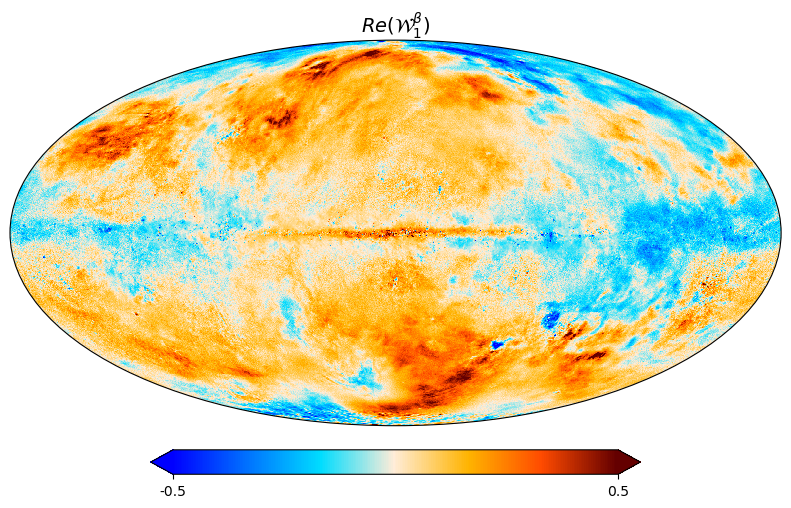

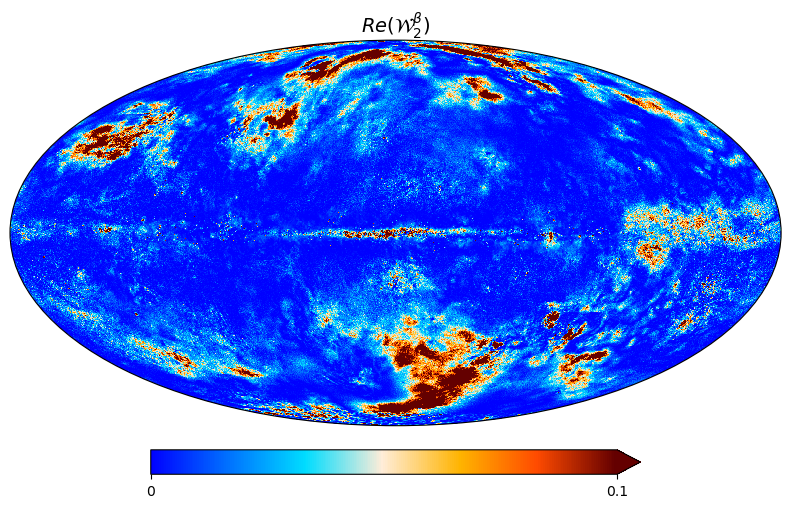

In [5]:
# plot of some of the moment maps. For pure 2D models (d1,d10), imaginary part should be compatible with zero if and only if no betabar and tempbar is specified, while d12 must have an imaginary part.

hp.projview(
    mom[1, 1, 0].real,
    cmap="planck",
    title=r"$Re(\mathcal{W}_1^\beta)$",
    min=-0.5,
    max=0.5,
)
plt.show()

hp.projview(
    mom[1, 2, 0].real, cmap="planck", title=r"$Re(\mathcal{W}_2^\beta)$", min=0, max=0.1
)
plt.show()

# Look at the median SED

We now compare the moment expansion at different orders with the original Pysm model over all the frequency range of a given instrument (here LiteBIRD or Planck).

To do so, we look at the median value of the quantity 

$$\frac{\Delta X_\alpha}{X} = \frac{|\text{model-moments-order}(\alpha)- \text{model-Pysm}|}{\text{model-Pysm}},$$

which we express in $\%$

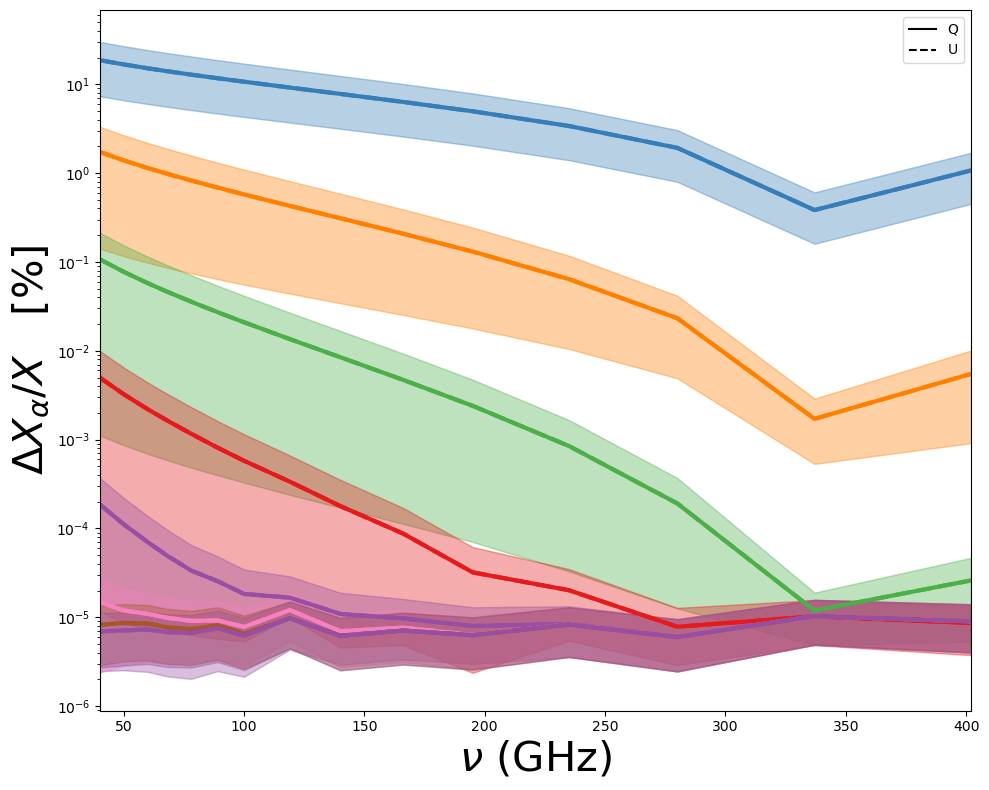

In [6]:
res = np.array([abs((modelmoms[i] - model) / model) * 100 for i in range(omax + 1)])

color = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#e41a1c",
    "#984ea3",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]
pol = 1  # I,Q,U = 0,1,2
plt.figure(figsize=(10, 8))
ln = ["-", "-", "--"]
polname = ["I", "Q", "U"]
plt.plot(freq, np.zeros(N_freq), linestyle="-", c="k", label="Q")
plt.plot(freq, np.zeros(N_freq), linestyle="--", c="k", label="U")
for i in range(omax + 1):
    for pol in [1, 2]:
        plt.plot(
            freq,
            np.median(res[i], axis=2)[:, pol],
            c=color[i],
            linestyle=ln[pol],
            linewidth=3,
        )
        plt.fill_between(
            freq,
            np.median(res[i], axis=2)[:, pol] - mad(res[i], axis=2)[:, pol],
            np.median(res[i], axis=2)[:, pol] + mad(res[i], axis=2)[:, pol],
            alpha=0.2,
            color=color[i],
        )
plt.xlim([freq[0], freq[N_freq - 1]])
# plt.ylim([5e-12,20])
plt.semilogy()
plt.xlabel(r"$\nu$ (GHz)", fontsize=30)
plt.ylabel(r"$\Delta X_\alpha/X$" + r"$\quad[\%]$", fontsize=30)
plt.legend()
plt.tight_layout()

# Computing residuals at a given frequency

We now compare moment expansion at different orders with the Pysm model at a given frequency. 

In [7]:
# At which frequency to investigate the value of the residuals?
f = 100  # GHz
idf = list(freq).index(f)

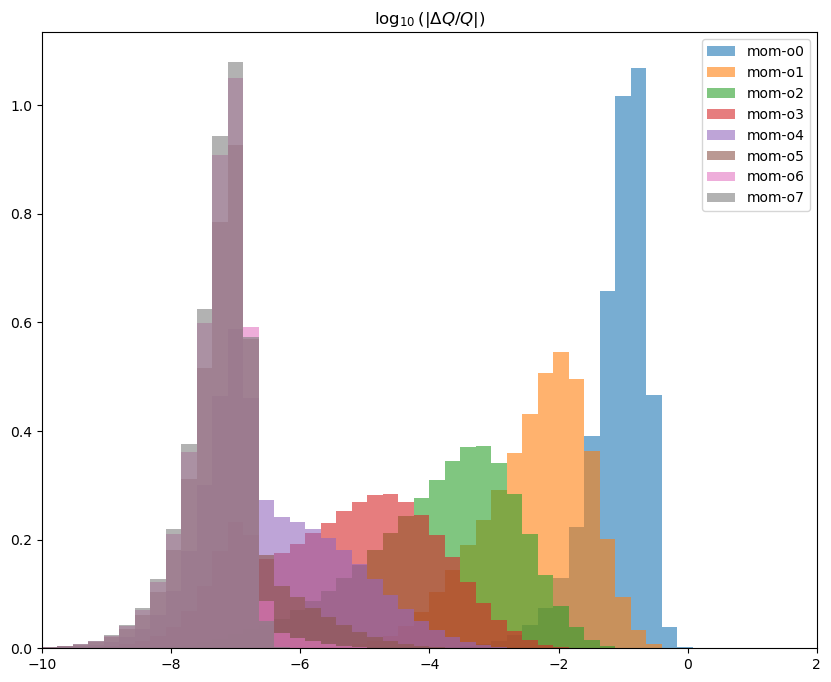

In [8]:
# simple histograms of residuals

pol = 1  # 0,1,2=I,Q,U
labelpol = ["I", "Q", "U"]
ranged = [-10, 2]  # range of the powers of 10
plt.figure(figsize=(10, 8))
for i in range(omax + 1):
    plt.hist(
        np.log10(
            abs((model[idf, pol] - modelmoms[i, idf, pol]) / modelmoms[i, idf, pol])
        ),
        label=r"mom-o%s" % i,
        bins=50,
        alpha=0.6,
        density=True,
        range=ranged,
    )  # ,weights=np.ones(51)/188241.46)
plt.xlim(ranged)
plt.title(r"$\log_{10}(|\Delta %s/%s|)$" % (labelpol[pol], labelpol[pol]))
plt.legend()
plt.show()

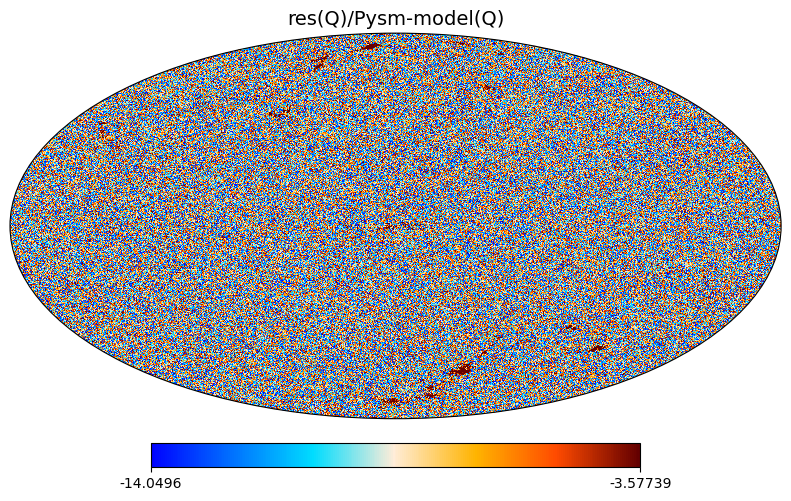

In [9]:
# plot of the log10 relative residual maps for maximum order of the expansion (also displayed in histograms previously). Should look like white noise when the only limit is python precision.
res = abs(model[idf, pol] - modelmoms[omax, idf, pol])
hp.projview(
    np.log10(abs(res / modelmoms[i, idf, pol])),
    cmap="planck",
    norm="hist",
    title="res(%s)/Pysm-model(%s)" % (labelpol[pol], labelpol[pol]),
)  # ,min=-3, max=-1)

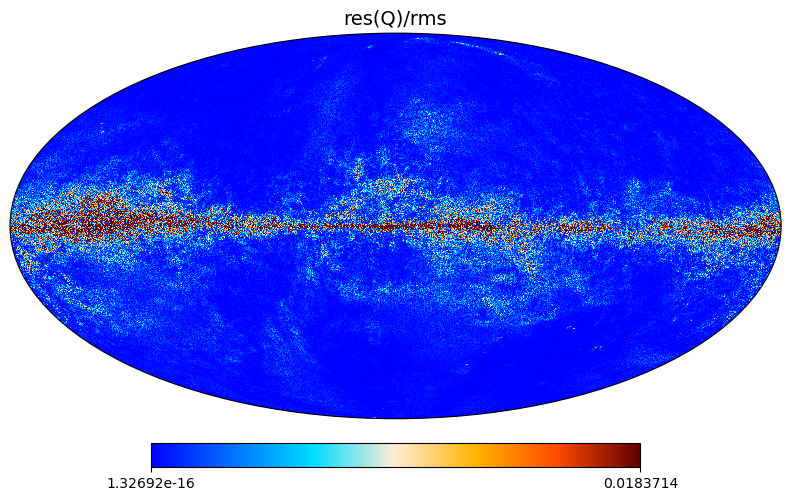

In [10]:
# plot of the residuals compared to litebird's resolution in the pixel. Lower than one --> difference impossible to detect for a LB-like experiment

sigpix_f = sigpix[idf]
hp.projview(
    res / sigpix_f, cmap="planck", norm="hist", title="res(%s)/rms" % (labelpol[pol])
)  # min=0, max=0.01,

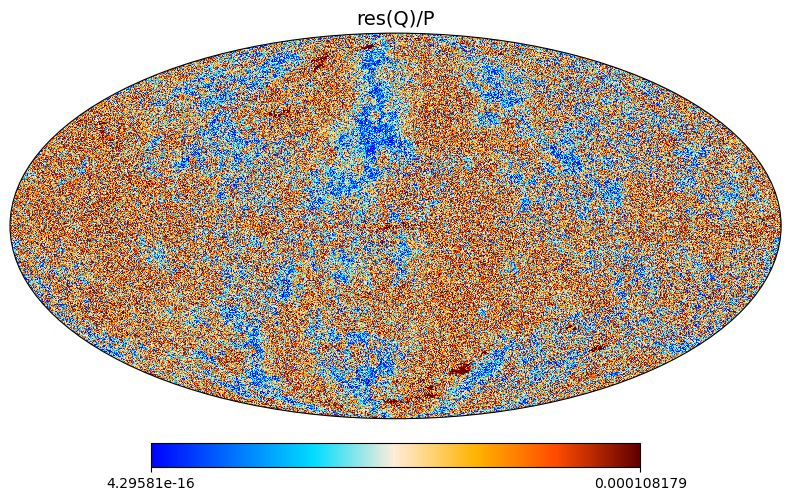

In [11]:
# plot of the residuals compared to the value of the polarized intensity of the original Pysm model in each pixel

hp.projview(
    res / abs(model[idf, 1] + 1j * model[idf, 2]),
    cmap="planck",
    norm="hist",
    title="res(%s)/P" % (labelpol[pol]),
)  # min=0, max=0.01,